In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

compat_rename = {'Ultimate Tensile Strength': 'Tensile Strength, Ultimate',
                 'Yield Strength': 'Tensile Strength, Yield',
                 'Elongation': 'Elongation at Break',
                 'names': 'Name'}

In [2]:
nickel_data = pd.read_csv("full_set.csv", index_col=0)
# nickel_data = nickel_data.drop(columns="Name")
nickel_data = nickel_data.rename(columns=compat_rename)
nickel_data.head()

,Name,"Tensile Strength, Yield",Pressure treated,Area under heat treatment curve,Strengthening Precipitate Phase,Powder processed,Al,B,C,Co,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,Allvac718PLUS,989.0,No,392890.0,GammaPrime,No,1.5,0.005,0.020,9.1,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,HastelloyS,NaN,No,0.0,NaN,No,0.3,0.000,0.000,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,Haynes230,NaN,No,0.0,NaN,No,0.3,0.000,0.100,0.0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Waspaloy,NaN,No,19572.0,NaN,No,1.3,0.001,0.035,13.4,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Unnamedalloy10,NaN,No,0.0,NaN,No,5.7,0.000,0.000,15.0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train for Elongation

In [3]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

elong_data = hf.clean_dataframe(nickel_data, 'Elongation at Break')
elong_data.head()

,Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,La,...,Zr,Elongation at Break,Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
5,12349.0,0.00,0.00,0.050,0.000000,20.000000,0.0,0.00,0.0,0.0,...,0.000,26.400000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,5.00,0.02,0.070,18.530001,12.380000,0.0,0.00,0.0,0.0,...,0.060,22.700001,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12,4441.0,0.00,0.00,0.150,20.000000,21.000000,0.0,30.00,0.0,0.0,...,0.000,30.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,24006.0,2.50,0.03,0.025,14.750000,16.000000,0.0,0.00,0.0,0.0,...,0.035,17.299999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16,3470.0,0.28,0.00,0.026,0.000000,21.280001,0.0,1.41,0.0,0.0,...,0.000,47.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [4]:

elong_train_data = elong_data.sample(frac=0.8, random_state=1300)
elong_test_data = elong_data.drop(elong_train_data.index)

elong_data.head()

,Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,La,...,Zr,Elongation at Break,Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
5,12349.0,0.00,0.00,0.050,0.000000,20.000000,0.0,0.00,0.0,0.0,...,0.000,26.400000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,5.00,0.02,0.070,18.530001,12.380000,0.0,0.00,0.0,0.0,...,0.060,22.700001,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12,4441.0,0.00,0.00,0.150,20.000000,21.000000,0.0,30.00,0.0,0.0,...,0.000,30.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,24006.0,2.50,0.03,0.025,14.750000,16.000000,0.0,0.00,0.0,0.0,...,0.035,17.299999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16,3470.0,0.28,0.00,0.026,0.000000,21.280001,0.0,1.41,0.0,0.0,...,0.000,47.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [5]:
elong_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Area under heat treatment curve,718.0,33014.257812,145323.546875,0.0,6621.799805,14223.000000,24530.0000,1.743038e+06
Al,718.0,2.390334,1.988406,0.0,0.520000,1.900000,3.9675,6.600000e+00
B,718.0,0.010371,0.015631,0.0,0.000000,0.006000,0.0150,1.600000e-01
C,718.0,0.061688,0.044427,0.0,0.028000,0.050000,0.0800,1.800000e-01
Co,718.0,8.426880,8.048764,0.0,0.000000,9.000000,14.7500,3.500000e+01
Cr,718.0,15.810961,4.822976,0.0,14.000000,16.400000,19.0000,2.950000e+01
Cu,718.0,0.002786,0.074639,0.0,0.000000,0.000000,0.0000,2.000000e+00
Fe,718.0,7.370613,11.729382,0.0,0.000000,0.000000,18.0000,4.522000e+01
Hf,718.0,0.086212,0.323045,0.0,0.000000,0.000000,0.0000,1.800000e+00
La,718.0,0.000279,0.003112,0.0,0.000000,0.000000,0.0000,5.000000e-02


In [6]:
elong_train_features = elong_train_data.copy()
elong_test_features = elong_test_data.copy()

elong_train_labels = elong_train_features.pop('Elongation at Break')
elong_test_labels = elong_test_features.pop('Elongation at Break')

In [7]:
elong_normalizer = hf.normalize(elong_train_features)

First example: [[ 0.    0.3   0.    0.1   0.   22.    0.    0.    0.    0.02  0.    0.5
   2.    0.    0.   57.    0.    0.    0.    0.4   0.    0.    0.   14.
   0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]]

Normalized: [[-0.23 -1.05 -0.66  0.86 -1.05  1.28 -0.04 -0.63 -0.27  6.34 -0.12  1.9
  -0.57 -0.13 -0.76  0.06 -0.28 -0.07  0.    1.57 -0.39 -1.31 -0.17  4.92
  -0.14 -0.07 -0.16 -0.48 -0.24 -0.21 -0.54 -1.38  4.49 -0.07 -0.15 -0.47]]


In [8]:
def builder(hp): return hf.model_builder_variable(hp,
                                                  elong_normalizer,
                                                  test_layers=[1,2,3],
                                                  dropout=0.5,
                                                  layer_1_nodes=[50,100,150,200,250],
                                                  layer_2_nodes=[50,100,150,200,250],
                                                  layer_3_nodes=[50,100,150,200,250])

In [9]:
# tuner = kt.RandomSearch(builder,
#                      objective='val_loss',
#                      max_trials=100,
#                      overwrite=True,
#                      directory='model_search',
#                      project_name='yield_model')

tuner = kt.Hyperband(builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     overwrite=True,
                     directory='model_search',
                     project_name='elong_model')

tuner_es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [10]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 4
hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
layer_1_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_2_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_3_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}


In [11]:
tuner.search(elong_train_features, elong_train_labels, epochs=200, validation_split=0.2, callbacks=[tuner_es], verbose=2)


Trial 254 Complete [00h 00m 06s]
val_loss: 94.12224578857422

Best val_loss So Far: 53.09712600708008
Total elapsed time: 00h 07m 13s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary()

Results summary
Results in model_search\elong_model
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layers: 2
layer_1_nodes: 250
layer_2_nodes: 250
layer_3_nodes: 50
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 53.09712600708008
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 200
layer_2_nodes: 150
layer_3_nodes: 150
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 53.37459182739258
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 250
layer_2_nodes: 50
layer_3_nodes: 200
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 55.09545135498047
Trial summary
Hyperparameters:
hidden_layers: 2
layer_1_nodes: 250
layer_2_nodes: 200
layer_3_nodes: 50
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 55.67689895629883
Trial summary
Hyperparameters:
hidden_layers: 2
layer_1_nodes: 200
layer

In [13]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
best_hps.get_config()['values']

{'hidden_layers': 2,
 'layer_1_nodes': 250,
 'layer_2_nodes': 250,
 'layer_3_nodes': 50,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [15]:
elong_model = tuner.hypermodel.build(best_hps)

elong_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 36)                0         
                                                                 
 dense_2 (Dense)             (None, 250)               9250      
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 250)               62750     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                      

In [16]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = elong_model.fit(elong_train_features, elong_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=0)

Epoch 51: early stopping


In [17]:
# utils.plot_model(yield_model, show_layer_activations=True, show_shapes=True)

In [21]:
elong_model.evaluate(elong_test_features, elong_test_labels, verbose=1)

6/6 [==============================] - 0s 801us/step - loss: 103.1197 - root_mean_squared_error: 10.1548 - mean_absolute_error: 6.2465


[103.1197280883789, 10.15478801727295, 6.246500492095947]

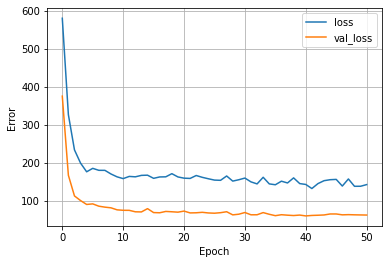

In [19]:
hf.plot_loss(history)

6/6 [==============================] - 0s 801us/step


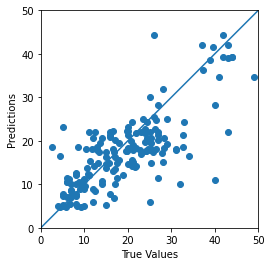

In [20]:
test_predictions = elong_model.predict(elong_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(elong_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)